In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import time
import tt
 
def rs(f1, f2, f, vx_l, vx_r):
    f = vx_l * f1 + vx_r * f2
    return f
    
def minmod(a, b):
    return np.where((a*b > 0), np.where(((abs(a) <= abs(b)) & (a*b > 0)), a, b), 0)    
    
def minmod2(a, b):
    if ((abs(a) <= abs(b)) & (a*b > 0)):
        return a
    elif (a*b > 0):
        return b
    else:
        return 0

def maxmod(a, b):
    return np.where((a*b > 0), np.where(((abs(a) >= abs(b)) & (a*b > 0)), a, b), 0)

def minmod_lim(u):
    return minmod(u[1:-1] - u[:-2], u[2:] - u[1:-1])

def superbee(u):
    return maxmod(minmod(u[2:] - u[1:-1], 2*(u[1:-1] - u[:-2])),
                             minmod(2*(u[2:] - u[1:-1]), u[1:-1] - u[:-2]))

def F_m(vx, vy, vz, T, n, Mol):
    Rg = 8.3144598 / Mol
    return n * ((1. / (2. * np.pi * Rg * T)) ** (3. / 2.)) * (np.exp(-(vx*vx + vy*vy + vz*vz) / (2. * Rg * T)))



def J(f, vmax, N):
    #fundamental constants
    Na = 6.02214129e+23
    kB = 1.381e-23 # J / K
    
    #gas parameters
    Mol = 40e-3 # kg / mol
    Rg = 8.3144598  / Mol  # J / (kg * K)
    m = Mol / Na # kg
    
    Pr = 2. / 3.
    C = 144.4
    T_0 = 273.11
    mu_0 = 2.125e-05

    #vmax = np.sqrt(2 * Rg * T) * 4
    #L = 21
    
    hv = 2. * vmax / N
    vx_ = np.linspace(-vmax+hv/2, vmax-hv/2, N)

    vx, vy, vz = np.meshgrid(vx_, vx_, vx_, indexing='ij')

    assert np.all(vx[:,0,0] == vx_)
    assert np.all(vy[0,:,0] == vx_)
    assert np.all(vz[0,0,:] == vx_)

    n = (hv ** 3) * np.sum(f)

    ux = (1. / n) * (hv ** 3) * np.sum(vx * f)
    uy = (1. / n) * (hv ** 3) * np.sum(vy * f)
    uz = (1. / n) * (hv ** 3) * np.sum(vz * f)
    
    v2 = vx*vx + vy*vy + vz*vz
    u2 = ux*ux + uy*uy + uz*uz
    
    T = (1. / (3. * n * Rg)) * ((hv ** 3) * np.sum(v2 * f) - n * u2)

    Vx = vx - ux
    Vy = vy - uy
    Vz = vz - uz

    rho = m * n

    p = rho * Rg * T

    cx = Vx / ((2. * Rg * T) ** (1. / 2.))
    cy = Vy / ((2. * Rg * T) ** (1. / 2.))
    cz = Vz / ((2. * Rg * T) ** (1. / 2.))
    
    c2 = cx*cx + cy*cy + cz*cz

    Sx = (1. / n) * (hv ** 3) * np.sum(cx * c2 * f)
    Sy = (1. / n) * (hv ** 3) * np.sum(cy * c2 * f)
    Sz = (1. / n) * (hv ** 3) * np.sum(cz * c2 * f)

    mu = mu_0 * ((T_0 + C) / (T + C)) * ((T / T_0) ** (3. / 2.))

    f_plus = F_m(Vx, Vy, Vz, T, n, Mol) * (1. + (4. / 5.) * (1. - Pr) * (cx*Sx + cy*Sy + cz*Sz) * (c2 - (5. / 2.)))

    J = (f_plus - f) * (p / mu)

    return J, n, ux, T

def J_tt(f, vmax, N):
    #fundamental constants
    Na = 6.02214129e+23
    kB = 1.381e-23 # J / K
    
    #gas parameters
    Mol = 40e-3 # kg / mol
    Rg = 8.3144598  / Mol  # J / (kg * K) 
    m = Mol / Na # kg
    
    Pr = 2. / 3.
    C = 144.4
    T_0 = 273.11
    mu_0 = 2.125e-05

    #vmax = np.sqrt(2 * Rg * T) * 4
    #L = 21
    
    hv = 2. * vmax / N
    vx_ = np.linspace(-vmax+hv/2, vmax-hv/2, N)

    vx, vy, vz = np.meshgrid(vx_, vx_, vx_, indexing='ij')

    assert np.all(vx[:,0,0] == vx_)
    assert np.all(vy[0,:,0] == vx_)
    assert np.all(vz[0,0,:] == vx_)

    vx_tt = tt.tensor(vx)
    vy_tt = tt.tensor(vy)
    vz_tt = tt.tensor(vz)

    n = (hv ** 3) * tt.sum(f)

    ux = (1. / n) * (hv ** 3) * tt.sum(vx_tt * f)
    uy = (1. / n) * (hv ** 3) * tt.sum(vy_tt * f)
    uz = (1. / n) * (hv ** 3) * tt.sum(vz_tt * f)
    
    v2 = vx_tt*vx_tt + vy_tt*vy_tt + vz_tt*vz_tt
    u2 = ux*ux + uy*uy + uz*uz
    
    T = (1. / (3. * n * Rg)) * ((hv ** 3) * tt.sum(v2 * f) - n * u2)

    Vx = vx - ux
    Vy = vy - uy
    Vz = vz - uz
    
    Vx_tt = vx_tt - ux * tt.ones((N,N,N))
    Vy_tt = vy_tt - uy * tt.ones((N,N,N))
    Vz_tt = vz_tt - uz * tt.ones((N,N,N))

    rho = m * n

    p = rho * Rg * T

    cx = Vx_tt * (1. / ((2. * Rg * T) ** (1. / 2.)))
    cy = Vy_tt * (1. / ((2. * Rg * T) ** (1. / 2.)))   
    cz = Vz_tt * (1. / ((2. * Rg * T) ** (1. / 2.)))
    
    c2 = cx*cx + cy*cy + cz*cz

    Sx = (1. / n) * (hv ** 3) * tt.sum(cx * c2 * f)
    Sy = (1. / n) * (hv ** 3) * tt.sum(cy * c2 * f)
    Sz = (1. / n) * (hv ** 3) * tt.sum(cz * c2 * f)

    mu = mu_0 * ((T_0 + C) / (T + C)) * ((T / T_0) ** (3. / 2.))

    F_M = tt.tensor(F_m(Vx, Vy, Vz, T, n, Mol))
    
    f_plus = F_M * (tt.ones((N,N,N)) + (4. / 5.) * (1. - Pr) * (cx*Sx + cy*Sy + cz*Sz) * (c2 - (5. / 2.) * tt.ones((N,N,N))))
    
    J = (f_plus - f) * (p / mu)
    
    return J, n, ux, T

In [2]:
def solver(x_l, x_r, L, Tau, CFL, vmax, N, n_l, u_l, T_l):
    
    Mol = 40e-3
    g = 5. / 3.
    
    h = (x_r - x_l) / L 
    tau = h * CFL / vmax / 10
    
    x = np.linspace(x_l+h/2, x_r-h/2, L)
    
    t = 0.
    
    hv = 2. * vmax / N
    vx_ = np.linspace(-vmax+hv/2, vmax-hv/2, N)
    vx, vy, vz = np.meshgrid(vx_, vx_, vx_, indexing='ij')
    
    vx_l = np.zeros((N, N, N))
    vx_r = np.zeros((N, N, N))
    
    for i in np.ndindex(vx.shape):
        if vx[i] > 0:
            vx_l[i] = vx[i]
        else:
            vx_l[i] = 0.
            
    vx_r = vx - vx_l
            
    vx_l = tt.tensor(vx_l)
    vx_r = tt.tensor(vx_r)
    
    M = u_l / ((g * Rg * T_l) ** .5)
    
    n_r = (g + 1.) * M * M / ((g - 1.) * M * M + 2.) * n_l
    u_r = ((g - 1.) * M * M + 2.) / ((g + 1.) * M * M) * u_l
    T_r = (2. * g * M * M - (g - 1.)) * ((g - 1.) * M * M + 2.) / ((g + 1) ** 2 * M * M) * T_l
    
    
    F_l = tt.tensor(F_m(vx-u_l, vy, vz, T_l, n_l, Mol))
    F_r = tt.tensor(F_m(vx-u_r, vy, vz, T_r, n_r, Mol))
    
#    vx = tt.tensor(vx)
#    vy = tt.tensor(vy)
#    vz = tt.tensor(vz)
    
    # initial condition 
#    f = list(F_l for i in range(L/2+1))
#    f = f.extend(list(F_r for i in range(L/2+1, L)))

    f = list(tt.tensor(np.zeros((N, N, N))) for i in range(L))
    
    for i in range(L/2+1):
        f[i] = F_l
    for i in range(L/2+1, L):
        f[i] = F_r
        
#    for i in range(L):
#        f[i] = tt.tensor(f[i])
    
    slope = list(tt.tensor(np.zeros((N, N, N))) for i in range(L))
    tmp = list(tt.tensor(np.zeros((N, N, N))) for i in range(L))
    f_l = list(tt.tensor(np.zeros((N, N, N))) for i in range(L+1))
    f_r = list(tt.tensor(np.zeros((N, N, N))) for i in range(L+1))
    Flow = list(tt.tensor(np.zeros((N, N, N))) for i in range(L+1))
    RHS = list(tt.tensor(np.zeros((N, N, N))) for i in range(L))
    j = list(tt.tensor(np.zeros((N, N, N))) for i in range(L))
    
    Dens = np.zeros(L)
    Vel = np.zeros(L)
    Temp = np.zeros(L)
    
    Frob_norm = np.array([])
    C_norm = np.array([])
    
    
    t1 = time.clock()
    
    while(t < Tau*tau):
        t += tau
        # boundary condition
        f_l[0] = F_l
        f_r[L] = F_r
        # reconstruction
        # compute slopes
        
        for i in range(1, L-1):
            slope[i] = (h * (f[i+1] - 2 * f[i] + f[i-1]))
            slope[i] = slope[i].round(1e-3)
#            slope[i] = slope[i].round(rmax=150)
            # insert ROUNDING!!!
#            slope[i, :, :, :] = h * minmod(f[i+1, :, :, :] - f[i, :, :, :], f[i, :, :, :] - f[i-1, :, :, :])
            
        for i in range(L):
            f_r[i] = f[i] - (h / 2) * slope[i]
            f_r[i] = f_r[i].round(1e-3)
        
        for i in range(1, L+1):
            f_l[i] = f[i-1] + (h / 2) * slope[i-1]
            f_l[i] = f_l[i].round(1e-3)
        
        # riemann solver - compute fluxes
        for i in range(L+1):
            Flow[i] = rs(f_l[i], f_r[i], Flow[i], vx_l, vx_r)
            Flow[i] = Flow[i].round(1e-3)
            
        # compute RHS
        for i in range(L):
            J_ = J_tt(f[i], vmax, N)
            RHS[i] = (- Flow[i+1] + Flow[i]) * (1. / h) + J_[0]
            RHS[i] = RHS[i].round(1e-3)
            
#            Frob_norm = np.append(Frob_norm, np.linalg.norm(RHS))
#            C_norm = np.append(C_norm, np.max(np.absolute(np.ravel(RHS))))

        # update values
        for i in range(L):
            tmp[i] = f[i] + tau * RHS[i]
            tmp[i] = tmp[i].round(1e-3)
            
        for i in range(L):    
            f[i] = tmp[i]
        
#        print np.linalg.norm(RHS)
#        print np.max(np.absolute((j)))
        
     
        
    t2 = time.clock() - t1
#    Dens = np.zeros(L)
#    Vel = np.zeros(L)
#    Temp = np.zeros(L)
    
    for i in range(L):
        J_ = J_tt(f[i], vmax, N)
        Dens[i] = J_[1].full()
        Vel[i] = J_[2].full()
        Temp[i] = J_[3].full()
        
    print "time =", t2
    
#    fig, ax = plt.subplots(figsize = (20,10))
#    line, = ax.semilogy(Frob_norm)
#    line.set_label('Frob_norm')
#    line, = ax.semilogy(C_norm)
#    line.set_label('C_norm')
#    ax.legend()
    
    return f, Dens, Vel, Temp

In [ ]:
d = 71e-12

Mol = 40e-3 # kg / mol
Rg = 8.3144598  / Mol  # J / (kg * K) 

L = 10
N = 10
vmax = 2000.

n_l = 2e+23 
u_l = 400.
T_l = 300.

l = 1. / ((2 ** .5) * np.pi * n_l * d * d)

x_l = -20*l
x_r = 20*l

Tau = 2

CFL = 0.5



S = solver(x_l = x_l, x_r = x_r, L = L, Tau = Tau, CFL = CFL, vmax = vmax,
           N = N, n_l = n_l, u_l = u_l, T_l = T_l)

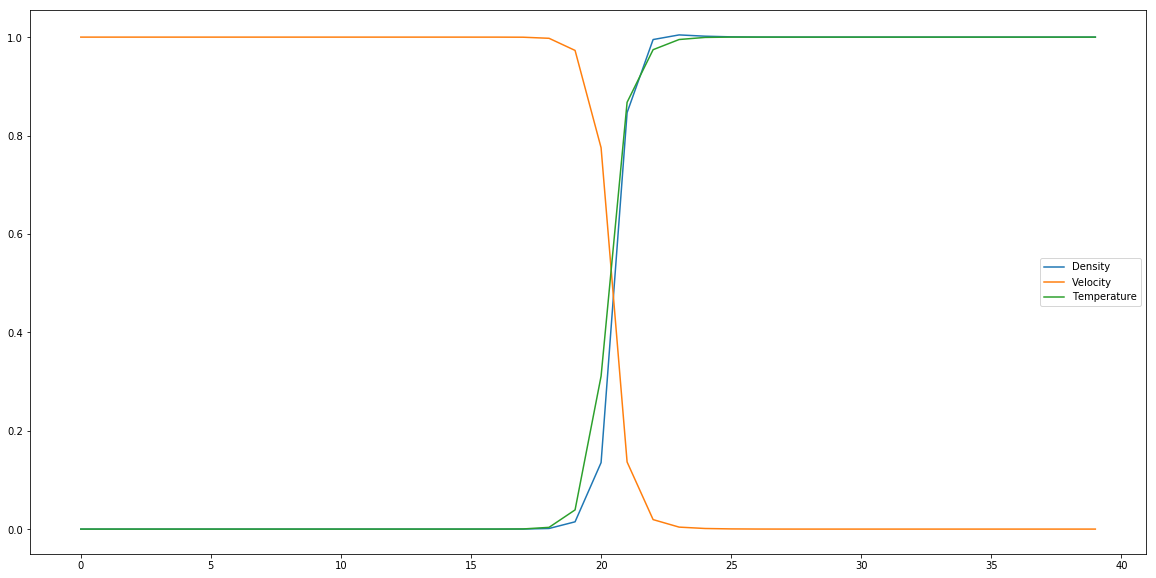

In [6]:
fig, ax = plt.subplots(figsize = (20,10))
line, = ax.plot((S[1] - n_l) / (n_r - n_l))
line.set_label('Density')
line, = ax.plot((S[2] - u_r) / (u_l - u_r))
line.set_label('Velocity')
line, = ax.plot((S[3] - T_l) / (T_r - T_l))
line.set_label('Temperature')
ax.legend()

#Frob_norm = 2.4855822240924352e+17

#ax.plot(F_l[:, N/2, N/2])
#ax.plot(F_r[:, N/2, N/2])
#ax.plot(Flow[:, N/2, N/2])

#print vx_

#ax.plot(F_r[:, 10, 10])
#print n_l, n_r
#print u_l, u_r
#print T_l, T_r

This is a 3-dimensional tensor 
r(0)=1, n(0)=40 
r(1)=1, n(1)=40 
r(2)=1, n(2)=40 
r(3)=1 

This is a 3-dimensional tensor 
r(0)=1, n(0)=40 
r(1)=1, n(1)=40 
r(2)=1, n(2)=40 
r(3)=1 

This is a 3-dimensional tensor 
r(0)=1, n(0)=40 
r(1)=2, n(1)=40 
r(2)=2, n(2)=40 
r(3)=1 

This is a 3-dimensional tensor 
r(0)=1, n(0)=40 
r(1)=1, n(1)=40 
r(2)=1, n(2)=40 
r(3)=1 

4.653055535050655e-23
3.6337840827951733e-23
This is a 2-dimensional tensor 
r(0)=1, n(0)=40 
r(1)=1, n(1)=40 
r(2)=1 

This is a 3-dimensional tensor 
r(0)=1, n(0)=40 
r(1)=2, n(1)=40 
r(2)=2, n(2)=40 
r(3)=1 



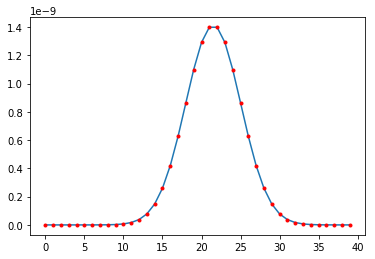

In [38]:
vmax = 2000.
N = 40
hv = 2*vmax/N
vx_ = np.linspace(-vmax+hv/2, vmax-hv/2, N)
vx, vy, vz = np.meshgrid(vx_, vx_, vx_, indexing='ij')

vx_tt = tt.tensor(vx)
vy_tt = tt.tensor(vy)
t = vx_tt + vy_tt
vx2_tt = vx_tt * vy_tt
# print(vx_tt)
# print(vy_tt)
# print(t)
# print(vx2_tt)
# vx2_tt[1,2,3] - vx[1,2,3]*vy[1,2,3]

f1 = F_m(vx, vy, vz, 300., 1., 20e-3) 
f2 = F_m(vx-200., vy, vz, 300., 1., 20e-3)
f3 = f1 + f2
f1_tt = tt.tensor(f1)
f2_tt = tt.tensor(f2)
print(f1_tt)
print(f2_tt)
f3_tt = f1_tt + f2_tt
print(f3_tt)
f3_tt_r = f3_tt.round(1e-3)
print(f3_tt_r)
plt.plot(f2[:,20,20])
f1_tt_full = f1_tt.full()
f2_tt_full = f2_tt.full()
plt.plot(f2_tt_full[:,20,20], 'r.')

print(np.linalg.norm(f3 - f3_tt.full()))
print(np.linalg.norm(f3 - f3_tt_r.full()))
f1_s = tt.sum(f1_tt, axis = 0)
print(f1_s)
f1m = f1_tt - 1e-8 * tt.ones((N,N,N))
print(f1m)

In [3]:
vmax = 2000.
N = 40
hv = 2*vmax/N
vx_ = np.linspace(-vmax+hv/2, vmax-hv/2, N)
vx, vy, vz = np.meshgrid(vx_, vx_, vx_, indexing='ij')



f = F_m(vx-1000., vy, vz, 300., 1., 20e-3) + 1e-20 * np.ones((N, N, N))
f_tt = tt.tensor(f)
j = J(f, vmax, N)[0]
j_tt = J_tt(f_tt, vmax, N)[0]
print j_tt
#plt.plot(j[20, 20, :])
#plt.plot(j_tt[20, 20, :].full(), 'r-')

This is a 3-dimensional tensor 
r(0)=1, n(0)=40 
r(1)=129, n(1)=40 
r(2)=129, n(2)=40 
r(3)=1 



In [4]:
d = 71e-12

Mol = 40e-3 # kg / mol
Rg = 8.3144598  / Mol  # J / (kg * K) 

n = 2e+23 
u = 400.
T = 300.

vx_l = np.zeros((N, N, N))
vx_r = np.zeros((N, N, N))
    
for i in np.ndindex(vx.shape):
    if vx[i] > 0:
        vx_l[i] = vx[i]
    else:
        vx_l[i] = 0.
            
vx_r = vx - vx_l
            
vx_l = tt.tensor(vx_l)
vx_r = tt.tensor(vx_r)

f = tt.tensor(np.zeros((N, N, N)))

f1 = tt.tensor(F_m(vx-100., vy, vz, T, n, Mol))
f2 = tt.tensor(F_m(vx+200., vy, vz, T, n, Mol))


print rs(f1, f2, f, vx_l, vx_r)

This is a 3-dimensional tensor 
r(0)=1, n(0)=40 
r(1)=2, n(1)=40 
r(2)=2, n(2)=40 
r(3)=1 



In [5]:
?j_tt.round()